In [1]:
from ydata_profiling import ProfileReport
from sklearn.model_selection import train_test_split
from sklearn.compose import ColumnTransformer
import numpy as np
from sklearn.impute import SimpleImputer
import matplotlib.pyplot as plt
%matplotlib inline
import pandas as pd
from sklearn.preprocessing import FunctionTransformer, OneHotEncoder, OrdinalEncoder, StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn import set_config
import torch
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix

/Users/muhammadshahzebali/myenv/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


# Load Dataset

#### Now we upload the Lending Club data. I have already downloaded it on my machine, and `load_data.py` will guide you through the loading process.


In [2]:
from load_data import load_lending_club_data

# Load the data
df = load_lending_club_data()
df.shape


(2260701, 151)

#### Our target variable has 9 classes, and the data is imbalanced. I attempted to convert it into a binary classification problem (default vs. not default), but the results were not good since the number of non-defaulters was quite low. We faced a similar issue when using four classes, but eventually achieved better results by consolidating into three classes.


In [3]:
print(df['loan_status'].value_counts())


loan_status
Fully Paid                                             1076751
Current                                                 878317
Charged Off                                             268559
Late (31-120 days)                                       21467
In Grace Period                                           8436
Late (16-30 days)                                         4349
Does not meet the credit policy. Status:Fully Paid        1988
Does not meet the credit policy. Status:Charged Off        761
Default                                                     40
Name: count, dtype: int64


#### We regrouped the original loan statuses into three categories:
- **Paid (0):** Fully Paid, Policy-Fully Paid  
- **Current (1):** Current  
- **Risky (2):** Charged Off, Default, Late, In Grace Period  

The code maps these raw statuses into a new column `loan_status_grouped`, drops any unmapped values (handling NaNs), and finally prints the class distribution to check balance across the three groups.


In [4]:

paid_statuses = [
    'Fully Paid',
    'Does not meet the credit policy. Status:Fully Paid'
]
current_status = ['Current']
risky_statuses = [
    'Charged Off',
    'Default',
    'Does not meet the credit policy. Status:Charged Off',
    'Late (31-120 days)',
    'Late (16-30 days)',
    'In Grace Period'
]

# Create mapping dictionary
status_to_class = {
    **{status: 0 for status in paid_statuses},  # Paid: 0
    **{status: 1 for status in current_status},  # Current: 1
    **{status: 2 for status in risky_statuses}  # Risky (Charged Off/Default + Delinquent): 2
}

# Map loan_status to 3 classes
df['loan_status_grouped'] = df['loan_status'].map(status_to_class)

# NaN check and debugging
if df['loan_status_grouped'].isna().any():
    unmapped = df[df['loan_status_grouped'].isna()]['loan_status'].unique()
    print(f"Warning: Unmapped loan_status values: {unmapped}")
    print(f"Dropping {df['loan_status_grouped'].isna().sum()} rows with NaN in loan_status_grouped")
    df = df.dropna(subset=['loan_status_grouped'])
    if df['loan_status_grouped'].isna().any():
        raise ValueError("NaNs persist in loan_status_grouped after dropping")
else:
    print("All loan_status values successfully mapped")

# Verify distribution
print("Distribution of loan_status_grouped:")
print(df['loan_status_grouped'].value_counts())

Dropping 33 rows with NaN in loan_status_grouped
Distribution of loan_status_grouped:
loan_status_grouped
0.0    1078739
1.0     878317
2.0     303612
Name: count, dtype: int64


## Check for missig Data

In [5]:
check = df.isnull().sum()/len(df)
cols = check[check > 0.05]


In [6]:
print(" Columns with > 5% Missing Data:")
for col, pct in cols.items():
    print(f"{col}: {pct:.2%}")

 Columns with > 5% Missing Data:
member_id: 100.00%
emp_title: 7.39%
emp_length: 6.50%
desc: 94.42%
mths_since_last_delinq: 51.25%
mths_since_last_record: 84.11%
next_pymnt_d: 59.51%
mths_since_last_major_derog: 74.31%
annual_inc_joint: 94.66%
dti_joint: 94.66%
verification_status_joint: 94.88%
open_acc_6m: 38.31%
open_act_il: 38.31%
open_il_12m: 38.31%
open_il_24m: 38.31%
mths_since_rcnt_il: 40.25%
total_bal_il: 38.31%
il_util: 47.28%
open_rv_12m: 38.31%
open_rv_24m: 38.31%
max_bal_bc: 38.31%
all_util: 38.32%
inq_fi: 38.31%
total_cu_tl: 38.31%
inq_last_12m: 38.31%
mo_sin_old_il_acct: 6.15%
mths_since_recent_bc_dlq: 77.01%
mths_since_recent_inq: 13.07%
mths_since_recent_revol_delinq: 67.25%
num_tl_120dpd_2m: 6.80%
revol_bal_joint: 95.22%
sec_app_fico_range_low: 95.22%
sec_app_fico_range_high: 95.22%
sec_app_earliest_cr_line: 95.22%
sec_app_inq_last_6mths: 95.22%
sec_app_mort_acc: 95.22%
sec_app_open_acc: 95.22%
sec_app_revol_util: 95.30%
sec_app_open_act_il: 95.22%
sec_app_num_rev_acct

In [6]:
# drop columns which have more than 80% missing data
cols_drop_initially = check[check > 0.8].index

In [7]:
df.drop(columns= cols_drop_initially, inplace= True)

#### Based on domain knowledge and data review, we dropped several columns due to issues such as duplication of information, high correlation with the target variable, or irrelevance for prediction. The full justification can be found in the profiling report (`initial_report.html`). The list of dropped columns is stored in `drop_cols` for reproducibility.


In [8]:
drop_cols = ['emp_title', 'mths_since_last_delinq', 'mths_since_last_major_derog', 'loan_status', 'sub_grade', 'initial_list_status', 
             'bc_util', 'mths_since_recent_bc_dlq', 'mths_since_recent_revol_delinq', 'issue_d', 'url', 'id', 'pymnt_plan', 'title', 'zip_code', 
             'last_pymnt_d', 'policy_code', 'il_util', 'mths_since_rcnt_il', 'open_rv_12m', 'open_rv_24m', 'open_il_12m', 'open_il_24m', 'open_act_il',
             'open_acc_6m', 'inq_fi', 'total_cu_tl', 'inq_last_12m' , 'total_rec_late_fee', 'tax_liens', 'acc_now_delinq', 'pub_rec', 'collections_12_mths_ex_med', 
             'emp_length', 'delinq_2yrs', 'inq_last_6mths', 'out_prncp', 'out_prncp_inv', 'recoveries', 'collection_recovery_fee', 'tot_coll_amt', 'total_bal_il',
             'max_bal_bc', 'all_util', 'chargeoff_within_12_mths', 'delinq_amnt', 'mort_acc', 'mths_since_recent_inq', 'num_accts_ever_120_pd', 'num_tl_120dpd_2m', 
             'num_tl_30dpd', 'num_tl_90g_dpd_24m', 'num_tl_op_past_12m', 'percent_bc_gt_75', 'pub_rec_bankruptcies', 'last_credit_pull_d', 'total_rev_hi_lim', 
             'acc_open_past_24mths', 'total_il_high_credit_limit', 'hardship_flag', 'debt_settlement_flag', 'addr_state', 'earliest_cr_line', 'bc_open_to_buy', 'mo_sin_rcnt_rev_tl_op', ]

In [9]:
drop_cols = [col for col in drop_cols if col in df.columns]
df.drop(columns=drop_cols, inplace=True)

In [10]:
df.shape

(2260668, 48)

#### Initial report on data

In [12]:

report = ProfileReport(df, title= "initial report")
report.to_file("initial_report.html")

In [11]:
pd.set_option('display.max.columns', None)
print(df.info())

<class 'pandas.core.frame.DataFrame'>
Index: 2260668 entries, 0 to 2260698
Data columns (total 48 columns):
 #   Column                Dtype  
---  ------                -----  
 0   loan_amnt             float64
 1   funded_amnt           float64
 2   funded_amnt_inv       float64
 3   term                  object 
 4   int_rate              float64
 5   installment           float64
 6   grade                 object 
 7   home_ownership        object 
 8   annual_inc            float64
 9   verification_status   object 
 10  purpose               object 
 11  dti                   float64
 12  fico_range_low        float64
 13  fico_range_high       float64
 14  open_acc              float64
 15  revol_bal             float64
 16  revol_util            float64
 17  total_acc             float64
 18  total_pymnt           float64
 19  total_pymnt_inv       float64
 20  total_rec_prncp       float64
 21  total_rec_int         float64
 22  last_pymnt_amnt       float64
 23  next_pymnt_d

# Train-test split

In [12]:

df['loan_status_grouped'] = df['loan_status_grouped'].astype(np.int64)

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(
    df.drop(columns=['loan_status_grouped']),
    df['loan_status_grouped'],
    test_size=0.2,
    random_state=42,
    stratify=df['loan_status_grouped']
)

In [13]:
print(X_train.shape)
print(X_test.shape)
print(y_train.shape)
print(y_test.shape)

(1808534, 47)
(452134, 47)
(1808534,)
(452134,)


In [14]:
X_train.head()

,loan_amnt,funded_amnt,funded_amnt_inv,term,int_rate,installment,grade,home_ownership,annual_inc,verification_status,purpose,dti,fico_range_low,fico_range_high,open_acc,revol_bal,revol_util,total_acc,total_pymnt,total_pymnt_inv,total_rec_prncp,total_rec_int,last_pymnt_amnt,next_pymnt_d,last_fico_range_high,last_fico_range_low,application_type,tot_cur_bal,avg_cur_bal,mo_sin_old_il_acct,mo_sin_old_rev_tl_op,mo_sin_rcnt_tl,mths_since_recent_bc,num_actv_bc_tl,num_actv_rev_tl,num_bc_sats,num_bc_tl,num_il_tl,num_op_rev_tl,num_rev_accts,num_rev_tl_bal_gt_0,num_sats,pct_tl_nvr_dlq,tot_hi_cred_lim,total_bal_ex_mort,total_bc_limit,disbursement_method
1831600,5325.0,5325.0,5325.0,36 months,16.78,189.27,C,MORTGAGE,80600.0,Verified,home_improvement,13.58,695.0,699.0,12.0,2511.0,78.5,24.0,6804.820000,6804.82,5325.00,1479.82,748.18,NaN,694.0,690.0,Individual,185756.0,15480.0,141.0,156.0,15.0,77.0,2.0,4.0,2.0,2.0,11.0,4.0,6.0,4.0,12.0,81.0,219972.0,34702.0,1100.0,Cash
1075982,12000.0,12000.0,12000.0,36 months,10.75,391.45,B,MORTGAGE,53000.0,Source Verified,debt_consolidation,23.26,680.0,684.0,14.0,9490.0,67.3,24.0,14084.837243,14084.84,12000.00,2084.84,391.26,NaN,804.0,800.0,Individual,125524.0,8966.0,66.0,411.0,11.0,11.0,4.0,8.0,5.0,13.0,2.0,11.0,21.0,9.0,14.0,100.0,154272.0,13466.0,7200.0,Cash
673524,10000.0,10000.0,10000.0,36 months,7.39,310.56,A,RENT,68000.0,Verified,debt_consolidation,4.29,715.0,719.0,5.0,1123.0,13.2,16.0,10240.270000,10240.27,9079.79,1160.48,310.56,Apr-2019,689.0,685.0,Individual,5644.0,1129.0,130.0,116.0,6.0,6.0,2.0,2.0,2.0,2.0,11.0,4.0,5.0,2.0,5.0,100.0,13500.0,5644.0,5500.0,Cash
955138,8800.0,8800.0,8800.0,36 months,7.49,273.70,A,MORTGAGE,48000.0,Not Verified,credit_card,24.10,695.0,699.0,18.0,18496.0,57.0,22.0,6030.560000,6030.56,5141.97,888.59,273.70,Apr-2019,614.0,610.0,Individual,20666.0,1148.0,71.0,112.0,0.0,30.0,6.0,17.0,7.0,7.0,4.0,17.0,18.0,16.0,18.0,100.0,45167.0,20666.0,15940.0,Cash
16502,20000.0,20000.0,20000.0,36 months,13.67,680.36,C,RENT,60000.0,Verified,credit_card,6.44,720.0,724.0,7.0,12085.0,41.2,25.0,21118.850000,21118.85,20000.00,1118.85,18412.60,NaN,774.0,770.0,Individual,12085.0,1726.0,110.0,163.0,11.0,11.0,3.0,6.0,4.0,7.0,7.0,7.0,15.0,6.0,7.0,100.0,29300.0,12085.0,18500.0,Cash


#### We created several custom transformers to handle domain-specific preprocessing tasks. All of these treatments are based on 'initial_report.html' These include:

- **TermToMonths** – converts loan terms like “36 months” into numeric values (e.g., 36).  
  *Why:* Machine learning models cannot interpret string durations; converting them into integers ensures the term length is usable as a numeric feature.

- **PercentileCapper** – caps extreme numeric values at the 99th percentile to reduce the impact of outliers.  
  *Why:* Outliers can heavily skew model training; capping them preserves most of the data while limiting noise.

- **SafeLog1p** – applies a safe logarithmic transform, replacing negatives with 0 before applying `log1p`.  
  *Why:* Log-scaling stabilizes highly skewed numeric distributions, but negatives would cause errors; clipping ensures numerical safety.

- **ReplaceValues** – replaces specified string values with new labels based on a mapping dictionary.  
  *Why:* This allows unifying inconsistent labels (e.g., “Yes”, “Y”, “1” → “Yes”) and ensures cleaner categorical features.

- **HomeOwnershipMerger** – merges rare home ownership categories (e.g., ANY, NONE, OTHER → OTHER).  
  *Why:* Reduces sparsity by consolidating categories with few samples, preventing the model from overfitting to rare labels.

- **RareCategoryGrouper** – groups infrequent categories into a single “OTHER” label if below a minimum frequency threshold.  
  *Why:* Ensures categorical features have stable representation by avoiding categories with very few examples.

- **MapStringBinary** – maps string values to binary values (e.g., yes/no → 1/0) with optional lowercase handling.  
  *Why:* Converts human-readable text into clean binary numeric features, which models can directly process.

These transformers are integrated into the scikit-learn pipeline, ensuring consistent preprocessing across training and evaluation. Each was designed to address either **data quality issues** (e.g., outliers, messy text, rare categories) or **model compatibility requirements** (e.g., converting strings into numbers).


In [15]:
set_config(transform_output="pandas")
class TermToMonths(BaseEstimator, TransformerMixin):
    def fit(self, X, y=None):
        self.name_ = X.columns[0]
        return self
    def transform(self, X):
        s = pd.Series(X.iloc[:, 0], index=X.index)
        out = pd.to_numeric(s, errors="coerce")  # handles already-numeric 36/60
        m = out.isna()
        if m.any():
            digs = pd.to_numeric(s[m].astype(str).str.extract(r"(\d+)")[0], errors="coerce")
            out.loc[m] = digs
        return pd.DataFrame(out.values, index=X.index, columns=[self.name_])

class PercentileCapper(BaseEstimator, TransformerMixin):
    def __init__(self, p=99): self.p=p
    def fit(self, X, y=None):
        self.name_ = X.columns[0]
        self.cap_  = np.nanpercentile(pd.to_numeric(X.iloc[:,0], errors="coerce"), self.p)
        return self
    def transform(self, X):
        x = pd.to_numeric(X.iloc[:,0], errors="coerce").clip(upper=self.cap_)
        return pd.DataFrame(x, columns=[self.name_])

class SafeLog1p(BaseEstimator, TransformerMixin):
    def fit(self, X, y=None): 
        return self
    def transform(self, X):
        name = X.columns[0]
        x = pd.to_numeric(X.iloc[:, 0], errors="coerce")
        # Replace negatives with 0 to keep it finite after log1p
        x = x.clip(lower=0)
        return pd.DataFrame(np.log1p(x), columns=[name])


class ReplaceValues(BaseEstimator, TransformerMixin):
    def __init__(self, mapping): self.mapping=mapping
    def fit(self, X, y=None):
        self.name_ = X.columns[0]; return self
    def transform(self, X):
        x = pd.Series(X.iloc[:,0])
        for old,new in self.mapping.items():
            x = x.mask(x==old, new)
        return pd.DataFrame(x, columns=[self.name_])

class HomeOwnershipMerger(BaseEstimator, TransformerMixin):
    def fit(self, X, y=None): return self
    def transform(self, X):
        name = X.columns[0]
        s = pd.Series(X.iloc[:,0]).astype(str).str.upper()
        s = s.replace({'ANY':'OTHER','NONE':'OTHER','OTHER':'OTHER'})
        return pd.DataFrame(s, columns=[name])

class RareCategoryGrouper(BaseEstimator, TransformerMixin):
    def __init__(self, min_freq=0.01, other_label="OTHER"):
        self.min_freq=min_freq; self.other_label=other_label
    def fit(self, X, y=None):
        s = pd.Series(X.iloc[:,0]).astype(str)
        freq = s.value_counts(normalize=True)
        self.keep_ = set(freq[freq >= self.min_freq].index)
        self.name_ = X.columns[0]
        return self
    def transform(self, X):
        s = pd.Series(X.iloc[:,0]).astype(str)
        s = s.where(s.isin(self.keep_), self.other_label)
        return pd.DataFrame(s, columns=[self.name_])

class MapStringBinary(BaseEstimator, TransformerMixin):
    def __init__(self, mapping=None, lowercase=True):
        self.mapping = mapping          # store params EXACTLY as passed
        self.lowercase = lowercase

    def fit(self, X, y=None):
        if self.mapping is None:
            raise ValueError("mapping must be provided")
        # create a fitted copy without mutating init params
        self.mapping_ = {str(k).lower(): v for k, v in self.mapping.items()} if self.lowercase else dict(self.mapping)
        self.name_ = X.columns[0]
        return self

    def transform(self, X):
        s = pd.Series(X.iloc[:, 0]).astype(str)
        if self.lowercase:
            s = s.str.lower()
        out = s.map(self.mapping_)
        return pd.DataFrame(out, columns=[self.name_])

# All Columns

In [17]:
all_cols = ['loan_amnt','funded_amnt','funded_amnt_inv','term','int_rate','installment','grade',
            'home_ownership','annual_inc','verification_status','purpose','dti','fico_range_low',
            'fico_range_high','open_acc','revol_bal','revol_util','total_acc','total_pymnt',
            'total_pymnt_inv','total_rec_prncp','total_rec_int','last_pymnt_amnt',
            'last_fico_range_high','last_fico_range_low','application_type','tot_cur_bal',
            'avg_cur_bal','mo_sin_old_il_acct','mo_sin_old_rev_tl_op','mo_sin_rcnt_tl',
            'mths_since_recent_bc','num_actv_bc_tl','num_actv_rev_tl','num_bc_sats','num_bc_tl',
            'num_il_tl','num_op_rev_tl','num_rev_accts','num_rev_tl_bal_gt_0','num_sats',
            'pct_tl_nvr_dlq','tot_hi_cred_lim','total_bal_ex_mort','total_bc_limit',
            'disbursement_method']

# Columns with issues

In [18]:
cols_29 = [
    'term','grade','home_ownership','annual_inc','verification_status','purpose','dti',
    'last_fico_range_low','application_type','tot_cur_bal','avg_cur_bal',
    'mo_sin_old_il_acct','mo_sin_old_rev_tl_op','mo_sin_rcnt_tl','mths_since_recent_bc',
    'num_actv_bc_tl','num_actv_rev_tl','num_bc_sats','num_bc_tl','num_il_tl','num_op_rev_tl',
    'num_rev_accts','num_rev_tl_bal_gt_0','num_sats','pct_tl_nvr_dlq','tot_hi_cred_lim',
    'total_bal_ex_mort','total_bc_limit','disbursement_method'
]

passthrough_cols = [c for c in all_cols if c not in cols_29]

#### We built a full preprocessing pipeline using scikit-learn’s `ColumnTransformer` to handle different feature types. Each feature group is treated with a tailored pipeline:
- **Grade →** Ordinally encoded according to the A–G credit grade order, with missing values imputed.  
- **Term →** Converted to numeric months using our custom transformer (`TermToMonths`) and imputed.  
- **Home Ownership →** Rare categories merged and then one-hot encoded.  
- **Verification & Purpose →** Encoded with one-hot; purpose also groups rare categories.  
- **Income & DTI →** Imputed, log-transformed, and capped to handle skew and outliers.  
- **Credit history variables →** Cleaned (e.g., replacing sentinel values like 0 or 999 with NaN), then capped or log-transformed as appropriate.  
- **Application type & disbursement →** Mapped to binary indicators.  
- **Remaining numeric variables →** Imputed with median values.  

Although the code for these specific treatments is largely self-explanatory, the **detailed mapping of individual transformations can also be found in `key.xlsx`**. This file documents the preprocessing applied to each column for reproducibility and reference.


# Pipeline creation 

In [19]:
grade_order = [["A","B","C","D","E","F","G"]]
grade_pipe = Pipeline([
    ("ord", OrdinalEncoder(categories=grade_order,
                           handle_unknown="use_encoded_value",
                           unknown_value=np.nan)),
    ("impute", SimpleImputer(strategy="most_frequent")),
])

term_pipe = Pipeline([
    ("to_months", TermToMonths()),
    ("impute", SimpleImputer(strategy="median")),
])

home_pipe = Pipeline([
    ("merge", HomeOwnershipMerger()),
    ("ohe", OneHotEncoder(handle_unknown="ignore", sparse_output=False)),
])

verification_pipe = OneHotEncoder(handle_unknown="ignore", sparse_output=False)

purpose_pipe = Pipeline([
    ("rare", RareCategoryGrouper(min_freq=0.01)),
    ("ohe", OneHotEncoder(handle_unknown="ignore", sparse_output=False)),
])

annual_inc_pipe = Pipeline([
    ("impute", SimpleImputer(strategy="median")),
    ("log1p", SafeLog1p()),
])



dti_pipe = Pipeline([
    ("cap", PercentileCapper(p=99)),
    ("impute", SimpleImputer(strategy="median")),
    ("log1p", SafeLog1p()),  # now clips negatives to 0
])


fico_last_low_pipe = Pipeline([
    ("bound0toNaN", ReplaceValues({0: np.nan})),
    ("impute", SimpleImputer(strategy="median")),
])

app_type_pipe = Pipeline([
    ("map", MapStringBinary({"individual": 0.0, "joint app": 1.0})),
])

skewed_numeric_pipe = lambda: Pipeline([
    ("impute", SimpleImputer(strategy="median")),
    ("log1p", SafeLog1p()),
])

fix999_cap_pipe = Pipeline([
    ("fix999", ReplaceValues({999: np.nan})),
    ("impute", SimpleImputer(strategy="median")),
    ("cap", PercentileCapper(p=99)),
])

cap99_pipe = Pipeline([
    ("cap", PercentileCapper(p=99)),
    ("impute", SimpleImputer(strategy="median")),
])

impute_only_pipe = Pipeline([
    ("impute", SimpleImputer(strategy="median")),
])

disbursement_pipe = Pipeline([
    ("map", MapStringBinary({"cash": 0.0, "directpay": 1.0})),
])


# Column Transformer

In [20]:
preprocessor = ColumnTransformer(
    transformers=[
        ("term", term_pipe, ["term"]),
        ("grade", grade_pipe, ["grade"]),
        ("home", home_pipe, ["home_ownership"]),
        ("verification", verification_pipe, ["verification_status"]),
        ("purpose", purpose_pipe, ["purpose"]),
        ("annual_inc", annual_inc_pipe, ["annual_inc"]),
        ("dti", dti_pipe, ["dti"]),
        ("last_fico_range_low", fico_last_low_pipe, ["last_fico_range_low"]),
        ("application_type", app_type_pipe, ["application_type"]),
        ("tot_cur_bal", skewed_numeric_pipe(), ["tot_cur_bal"]),
        ("avg_cur_bal", skewed_numeric_pipe(), ["avg_cur_bal"]),
        ("mo_sin_old_il_acct", fix999_cap_pipe, ["mo_sin_old_il_acct"]),
        ("mo_sin_old_rev_tl_op", cap99_pipe, ["mo_sin_old_rev_tl_op"]),
        ("mo_sin_rcnt_tl", cap99_pipe, ["mo_sin_rcnt_tl"]),
        ("mths_since_recent_bc", cap99_pipe, ["mths_since_recent_bc"]),
        ("num_actv_bc_tl", cap99_pipe, ["num_actv_bc_tl"]),
        ("num_actv_rev_tl", cap99_pipe, ["num_actv_rev_tl"]),
        ("num_bc_sats", cap99_pipe, ["num_bc_sats"]),
        ("num_bc_tl", cap99_pipe, ["num_bc_tl"]),
        ("num_il_tl", cap99_pipe, ["num_il_tl"]),
        ("num_op_rev_tl", cap99_pipe, ["num_op_rev_tl"]),
        ("num_rev_accts", cap99_pipe, ["num_rev_accts"]),
        ("num_rev_tl_bal_gt_0", cap99_pipe, ["num_rev_tl_bal_gt_0"]),
        ("num_sats", cap99_pipe, ["num_sats"]),
        ("pct_tl_nvr_dlq", impute_only_pipe, ["pct_tl_nvr_dlq"]),
        ("tot_hi_cred_lim", Pipeline([("to99", cap99_pipe), ("log1p", SafeLog1p())]), ["tot_hi_cred_lim"]),
        ("total_bal_ex_mort", Pipeline([("to99", cap99_pipe), ("log1p", SafeLog1p())]), ["total_bal_ex_mort"]),
        ("total_bc_limit", Pipeline([("to99", cap99_pipe), ("log1p", SafeLog1p())]), ["total_bc_limit"]),
        ("disbursement_method", disbursement_pipe, ["disbursement_method"]),
        ("passthrough_rest", Pipeline([
            ("impute", SimpleImputer(strategy= "median")) ]),
            
            passthrough_cols),
    ],
    remainder="drop",
    verbose_feature_names_out=False
)

In [21]:
preprocessor

ColumnTransformer(transformers=[('term',
                                 Pipeline(steps=[('to_months', TermToMonths()),
                                                 ('impute',
                                                  SimpleImputer(strategy='median'))]),
                                 ['term']),
                                ('grade',
                                 Pipeline(steps=[('ord',
                                                  OrdinalEncoder(categories=[['A',
                                                                              'B',
                                                                              'C',
                                                                              'D',
                                                                              'E',
                                                                              'F',
                                                                              'G']],
                                                                 handle_unknown='use_encoded_value',
                                                                 unknown_value=nan)),
                                                 ('impute',
                                                  SimpleImputer(strategy='most_frequent'))]),
                                 ['grade']),...
                                 Pipeline(steps=[('impute',
                                                  SimpleImputer(strategy='median'))]),
                                 ['loan_amnt', 'funded_amnt', 'funded_amnt_inv',
                                  'int_rate', 'installment', 'fico_range_low',
                                  'fico_range_high', 'open_acc', 'revol_bal',
                                  'revol_util', 'total_acc', 'total_pymnt',
                                  'total_pymnt_inv', 'total_rec_prncp',
                                  'total_rec_int', 'last_pymnt_amnt',
                                  'last_fico_range_high'])],
                  verbose_feature_names_out=False)

#### After fitting the preprocessing pipeline, we transformed both the training and test datasets (`Xtr` and `X_test_preprocessed`). To verify the transformations, we generated an updated profiling report using **ydata-profiling**. The report provides insights into the processed features, distribution changes, and remaining data quality issues.  

The full updated report can be viewed in **`updated_report.html`**.


In [22]:
preprocessor.fit(X_train, y_train)
Xtr = preprocessor.transform(X_train)
X_test_preprocessed = preprocessor.transform(X_test)

/Users/muhammadshahzebali/myenv/lib/python3.12/site-packages/sklearn/pipeline.py:62: FutureWarning: This Pipeline instance is not fitted yet. Call 'fit' with appropriate arguments before using other methods such as transform, predict, etc. This will raise an error in 1.8 instead of the current warning.
  warnings.warn(
/Users/muhammadshahzebali/myenv/lib/python3.12/site-packages/sklearn/pipeline.py:62: FutureWarning: This Pipeline instance is not fitted yet. Call 'fit' with appropriate arguments before using other methods such as transform, predict, etc. This will raise an error in 1.8 instead of the current warning.
  warnings.warn(
/Users/muhammadshahzebali/myenv/lib/python3.12/site-packages/sklearn/pipeline.py:62: FutureWarning: This Pipeline instance is not fitted yet. Call 'fit' with appropriate arguments before using other methods such as transform, predict, etc. This will raise an error in 1.8 instead of the current warning.
  warnings.warn(
/Users/muhammadshahzebali/myenv/lib/p

In [24]:
report = ProfileReport(Xtr, title="Updated report", minimal=True)
report.to_file("updated_report.html")

In [23]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

#### We applied feature scaling using **StandardScaler**.  
- The scaler was fitted on the training set (`Xtr`) to learn the mean and standard deviation of each feature.  
- Both training and test data were then transformed so that all features have **mean = 0** and **variance = 1**.  
- This ensures consistent scaling across datasets and helps the neural network train more efficiently by preventing features with larger ranges from dominating the model.


In [24]:
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(Xtr)
X_test_scaled = scaler.transform(X_test_preprocessed)

In [27]:
print(X_train_scaled.shape) 
print(X_test_scaled.shape) 

(1808534, 59)
(452134, 59)


# 1) Create CustomDataset Class

In [25]:
from torch.utils.data import Dataset, DataLoader

class CustomDataset(Dataset):
    def __init__(self, features, labels):
        if hasattr(features, "values"):  # DataFrame/Series
            features = features.values
        if hasattr(labels, "values"):
            labels = labels.values
        self.features = torch.tensor(features, dtype=torch.float32)
        self.labels = torch.tensor(labels, dtype=torch.long)
 

    def __len__(self):
        return len(self.features)

    def __getitem__(self, index):
        return self.features[index], self.labels[index]

# 2) Cretae train-test dataset object

In [26]:
train_dataset = CustomDataset(X_train_scaled, y_train)
test_dataset = CustomDataset(X_test_scaled, y_test)

In [27]:
print(train_dataset.features.shape)
print(train_dataset.labels.shape) 
print(test_dataset.features.shape) 
print(test_dataset.labels.shape) 

torch.Size([1808534, 59])
torch.Size([1808534])
torch.Size([452134, 59])
torch.Size([452134])


# 3) Create train-test loader

In [28]:
train_loader = DataLoader(train_dataset, batch_size=64, shuffle= True)
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False)

# 4) Define NN

In [29]:
import torch.nn as nn

class ResidualBlock(nn.Module):
    def __init__(self, features):
        super().__init__()
        self.block = nn.Sequential(
            nn.Linear(features, features),
            nn.BatchNorm1d(features),
            nn.LeakyReLU(0.1),
            nn.Dropout(0.3)
        )
    
    def forward(self, x):
        return x + self.block(x)  # Residual connection

class MyNN(nn.Module):
    def __init__(self, num_features=59, num_classes=3):
        super().__init__()
        self.model = nn.Sequential(
            nn.Linear(num_features, 256),
            nn.BatchNorm1d(256),
            nn.LeakyReLU(0.1),
            nn.Dropout(p= 0.3),

            
            nn.Linear(256, 128),
            nn.BatchNorm1d(128),
            nn.LeakyReLU(0.1),
            nn.Dropout(0.3),
            
          ResidualBlock(128),
            
            nn.Linear(128, 64),
            nn.BatchNorm1d(64),
            nn.LeakyReLU(0.1),
            
            nn.Linear(64, num_classes)
        )

        

    def forward(self, x): 
        return self.model(x)

# 5) set laerning rate and epochs

In [30]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
import torch.optim as optim
# Class weights handling
class_counts = np.array([1078739, 878317, 303612])
class_weights = 1.0 / class_counts
class_weights = class_weights / class_weights.sum() * len(class_counts)
class_weights = torch.tensor(class_weights, dtype=torch.float32).to(device)

# Model, loss, and optimizer
model = MyNN(num_features=59, num_classes=3).to(device)
criterion = nn.CrossEntropyLoss(weight=class_weights)
optimizer = optim.AdamW(model.parameters(), lr=0.001, weight_decay=1e-4)

# Learning rate scheduler
scheduler = optim.lr_scheduler.ReduceLROnPlateau(
    optimizer, 
    mode='min',
    factor=0.5,
    patience=2,
    threshold= 0.001
    
)

#### We computed **class weights** to handle imbalance in the three-class target variable.  
- First, we defined the raw counts of each class: `[1078739, 878317, 303612]`.  
- Class weights were set as the inverse of these counts (`1.0 / class_counts`), giving higher weight to minority classes.  
- The weights were then normalized so their sum equals the number of classes, ensuring balanced contribution across categories.  
These weights are later passed to the loss function so that the model does not become biased toward the majority class.


In [53]:
# Training loop
epochs = 30
best_val_loss = float('inf')
patience = 5 
no_improve = 0
prev_lr = learning_rate

train_losses = []
val_losses = []
val_accuracies = []

for epoch in range(epochs):
    # Training
    model.train()
    total_train_loss = 0
    total_samples = 0
    correct_train = 0
    
    for batch_features, batch_labels in train_loader:
        batch_features, batch_labels = batch_features.to(device), batch_labels.to(device)
        
        # Forward pass
        outputs = model(batch_features)
        loss = criterion(outputs, batch_labels)
        
        # Backward pass
        optimizer.zero_grad()
        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)
        optimizer.step()
        
        # Track metrics
        total_train_loss += loss.item() * batch_labels.size(0)
        _, predicted = torch.max(outputs, 1)
        correct_train += (predicted == batch_labels).sum().item()
        total_samples += batch_labels.size(0)
    
    avg_train_loss = total_train_loss / total_samples
    train_accuracy = correct_train / total_samples
    train_losses.append(avg_train_loss)
    
    # Validation phase
    model.eval()
    total_val_loss = 0
    total_val_samples = 0
    correct_val = 0
    
    with torch.no_grad():
        for batch_features, batch_labels in test_loader:
            batch_features, batch_labels = batch_features.to(device), batch_labels.to(device)
            outputs = model(batch_features)
            loss = criterion(outputs, batch_labels)
            
            total_val_loss += loss.item() * batch_labels.size(0)
            _, predicted = torch.max(outputs, 1)
            correct_val += (predicted == batch_labels).sum().item()
            total_val_samples += batch_labels.size(0)
    
    avg_val_loss = total_val_loss / total_val_samples
    val_accuracy = correct_val / total_val_samples
    val_losses.append(avg_val_loss)
    val_accuracies.append(val_accuracy)
    
    # Update scheduler
    scheduler.step(avg_val_loss)
    
    # Check for learning rate
    current_lr = optimizer.param_groups[0]['lr']
    if current_lr < prev_lr:
        print(f"LR reduced from {prev_lr} to {current_lr}")
        no_improve = 0  # Reset counter on LR reduction
        prev_lr = current_lr
    
    # Early stopping
    if avg_val_loss < best_val_loss:
        best_val_loss = avg_val_loss
        no_improve = 0
        torch.save(model.state_dict(), 'best_model.pth')
        print(f'Epoch {epoch+1}: Validation loss improved to {best_val_loss:.6f}. Model saved.')
    else:
        no_improve += 1
        print(f'Epoch {epoch+1}: No improvement ({no_improve}/{patience})')
    
    # Print metrics
    print(f'Epoch: {epoch+1:02d} | '
          f'Train Loss: {avg_train_loss:.6f} | Val Loss: {avg_val_loss:.6f} | '
          f'Train Acc: {train_accuracy:.4f} | Val Acc: {val_accuracy:.4f} | '
          f'LR: {current_lr:.6f}')
    
    # Early stopping check
    if no_improve >= patience:
        print(f'Early stopping triggered after {patience} epochs without improvement')
        break


print("\nTraining completed!")
print(f'Best validation loss: {best_val_loss:.6f}')
print(f'Best validation accuracy: {max(val_accuracies):.4f}')

# Load best model for final evaluation
model.load_state_dict(torch.load('best_model.pth'))

Epoch 1: Validation loss improved to 0.196824. Model saved.
Epoch: 01 | Train Loss: 0.225588 | Val Loss: 0.196824 | Train Acc: 0.9345 | Val Acc: 0.9389 | LR: 0.001000
Epoch 2: Validation loss improved to 0.172462. Model saved.
Epoch: 02 | Train Loss: 0.190366 | Val Loss: 0.172462 | Train Acc: 0.9487 | Val Acc: 0.9614 | LR: 0.001000
Epoch 3: No improvement (1/5)
Epoch: 03 | Train Loss: 0.182386 | Val Loss: 0.175429 | Train Acc: 0.9516 | Val Acc: 0.9503 | LR: 0.001000
Epoch 4: Validation loss improved to 0.162407. Model saved.
Epoch: 04 | Train Loss: 0.177304 | Val Loss: 0.162407 | Train Acc: 0.9531 | Val Acc: 0.9610 | LR: 0.001000
Epoch 5: No improvement (1/5)
Epoch: 05 | Train Loss: 0.174076 | Val Loss: 0.162954 | Train Acc: 0.9543 | Val Acc: 0.9631 | LR: 0.001000
Epoch 6: Validation loss improved to 0.155597. Model saved.
Epoch: 06 | Train Loss: 0.171110 | Val Loss: 0.155597 | Train Acc: 0.9554 | Val Acc: 0.9634 | LR: 0.001000
Epoch 7: No improvement (1/5)
Epoch: 07 | Train Loss: 0.16

<All keys matched successfully>

In [54]:
print("\nTraining completed!")
print(f'Best validation loss: {best_val_loss:.6f}')
print(f'Best validation accuracy: {max(val_accuracies):.4f}')


Training completed!
Best validation loss: 0.143037
Best validation accuracy: 0.9669


Classification Report:
                precision    recall  f1-score   support

 paid_statuses     0.9936    0.9967    0.9951    215748
current_status     0.9634    0.9529    0.9581    175664
risky_statuses     0.8839    0.9019    0.8928     60722

      accuracy                         0.9669    452134
     macro avg     0.9469    0.9505    0.9487    452134
  weighted avg     0.9671    0.9669    0.9670    452134



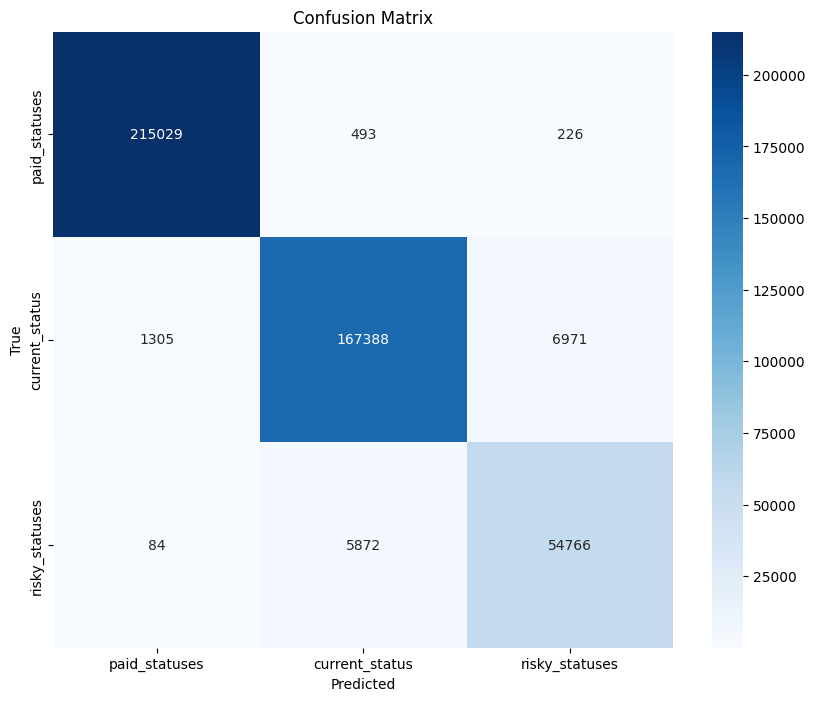


Balanced Accuracy: 0.9505
F1-Score for paid_statuses: 0.9951
F1-Score for current_status: 0.9581
F1-Score for risky_statuses: 0.8928


In [58]:
import seaborn as sns
model.load_state_dict(torch.load('best_model.pth'))
model.eval()


all_targets = []
all_preds = []

with torch.no_grad():
    for features, targets in test_loader:
        features, targets = features.to(device), targets.to(device)
        outputs = model(features)
        _, preds = torch.max(outputs, 1)
        all_targets.extend(targets.cpu().numpy())
        all_preds.extend(preds.cpu().numpy())

# Classification report
class_names = ['paid_statuses', 'current_status', 'risky_statuses']  
print("Classification Report:")
print(classification_report(all_targets, all_preds, target_names=class_names, digits=4))

# Confusion matrix
cm = confusion_matrix(all_targets, all_preds)
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
            xticklabels=class_names, yticklabels=class_names)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.savefig('confusion_matrix.png', bbox_inches='tight')
plt.show()

# Calculate accuracy
from sklearn.metrics import balanced_accuracy_score
bal_acc = balanced_accuracy_score(all_targets, all_preds)
print(f"\nBalanced Accuracy: {bal_acc:.4f}")

# Calculate F1 scores per class
from sklearn.metrics import f1_score
f1_per_class = f1_score(all_targets, all_preds, average=None)
for i, name in enumerate(class_names):
    print(f"F1-Score for {name}: {f1_per_class[i]:.4f}")